In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import RYGate
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
mu = 0.02             # Drift (expected return)
sigma = 0.1           # Volatility (random fluctuations)
gamma = 0.05          # Decoherence rate

In [ ]:
def Bernoulli_gate(p):
    return RYGate(2*np.arcsin(np.sqrt(p))) 


def styled_line_plot(x, y, title):
    plt.plot(x, y, marker='o', linestyle='-', color='royalblue', label="Quantum Brownian Motion")
    plt.xlabel("Time Steps")
    plt.ylabel("Asset Price")
    plt.title(title)
    plt.show()

In [ ]:
from qiskit_aer import AerSimulator


num_steps = 50      # Time steps in the evolution
P = 0.5             # Bernoulli p
B_0 = 0
values = [B_0]

simulator = AerSimulator()
time_steps = np.linspace(0, 1, num_steps + 1)
for t in time_steps[1:]:
    # Circuit definition
    qc = QuantumCircuit(1)
    qc.append(Bernoulli_gate(P), [0])
    qc.measure_all()
    
    # Run simulation
    result = simulator.run(qc, shots=1).result()
    counts = result.get_counts(qc)
    total = sum(counts.values())

    # Check outcome
    down = counts.get('0')
    up = counts.get('1')

    # Map to asset price: Measure |0> → price decreases, Measure |1> → price increases
    delta_sign = bool(down)*-1 + bool(up)*1
    S_t = values[-1] + np.sqrt(t) * sigma * delta_sign
    values.append(S_t)


styled_line_plot(time_steps, values, "Quantum Brownian Motion - Bernoulli")

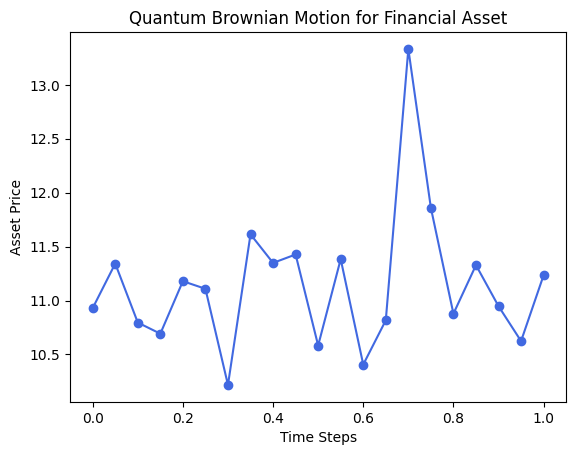

In [ ]:
from qiskit_aer import AerSimulator

num_shots = 1024      # Number of measurements (simulated market observations)
P = 0.5
SD = np.sqrt(P * (1 - P)/num_shots)

S_0 = 10.93
prices = [S_0]

simulator = AerSimulator()
time_steps = np.linspace(0, 1, num_steps + 1)
for t in time_steps[1:]:
    qc = QuantumCircuit(1)
    qc.append(Bernoulli_gate(P), [0])
    qc.measure_all()

    # # Encode initial price state (superposition for flexibility)
    # qc.h(0)  # Put qubit in superposition
    # qbm_step(qc, 0, mu, sigma, gamma)
    
    # Run simulation
    result = simulator.run(qc, shots=num_shots).result()
    counts = result.get_counts(qc)
    total = sum(counts.values())

    # Compute quantum probabilities
    price_down = counts.get('0') / num_shots
    price_up = counts.get('1') / num_shots

    random_norm = (price_up - P)/SD

    # Map to asset price: Higher prob of |0> → price increases, Higher prob of |1> → price decreases
    delta_sign = np.random.choice([-1, 1], size=1, p=[price_down, price_up])
    delta_magnitue = np.random.randn()**2
    delta = (delta_sign*delta_magnitue)[0]
    
    S_t = S_0 * np.exp((mu - sigma**2/2) * t + np.sqrt(t) * sigma * random_norm)
    prices.append(S_t)


styled_line_plot(time_steps, prices, "Quantum Brownian Motion for Financial Asset")

In [40]:
changes = []
for t in range(1000):
    qc = QuantumCircuit(1)
    qc.append(Bernoulli_gate(0.5), [0])
    # qc.h(0) 
    # qbm_step(qc, 0, mu, sigma, gamma)
    qc.measure_all()

    result = simulator.run(qc, shots=num_shots).result()
    counts = result.get_counts(qc)
    total = sum(counts.values())

    price_up = counts.get('0') / num_shots
    price_down = counts.get('1') / num_shots
    
    random_norm = (price_up - P)/SD
    changes.append(random_norm)

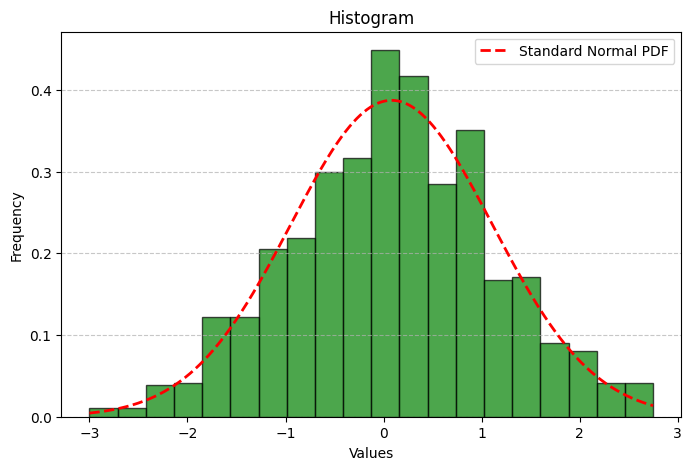

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

def plot_histogram(data, bins=10, title="Histogram", xlabel="Values", ylabel="Frequency", color="blue", alpha=0.7):
    """
    Plots a histogram for the given data and overlays a standard normal distribution.
    
    Parameters:
        data (array-like): Input data values.
        bins (int or sequence): Number of bins or bin edges.
        title (str): Title of the histogram.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        color (str): Color of the bars.
        alpha (float): Transparency level of bars (0 to 1).
    """
    plt.figure(figsize=(8, 5))
    
    # Plot histogram
    counts, bin_edges, _ = plt.hist(data, bins=bins, color=color, alpha=alpha, edgecolor='black', density=True)
    
    # Fit and plot standard normal distribution
    x = np.linspace(min(data), max(data), 1000)
    y = norm.pdf(x, np.mean(data), np.std(data))
    plt.plot(x, y, color='red', linestyle='--', linewidth=2, label='Standard Normal PDF')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


# plot_histogram((changes - np.mean(changes))/np.std(changes), bins=20, color="green")
plot_histogram(changes, bins=20, color="green")


In [7]:
np.std(changes)

np.float64(0.015464122843097066)

In [25]:
np.sqrt(num_shots*np.sqrt(0.5*0.5)/(num_shots**2))

np.float64(0.02209708691207961)